In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filepath = os.path.abspath('')
utilpath = f'{filepath}/../util/'
sys.path.append(utilpath)
data_dir = f'{filepath}/../data/'

melb_data = pd.read_hdf(f'{data_dir}/melb_data.h5')

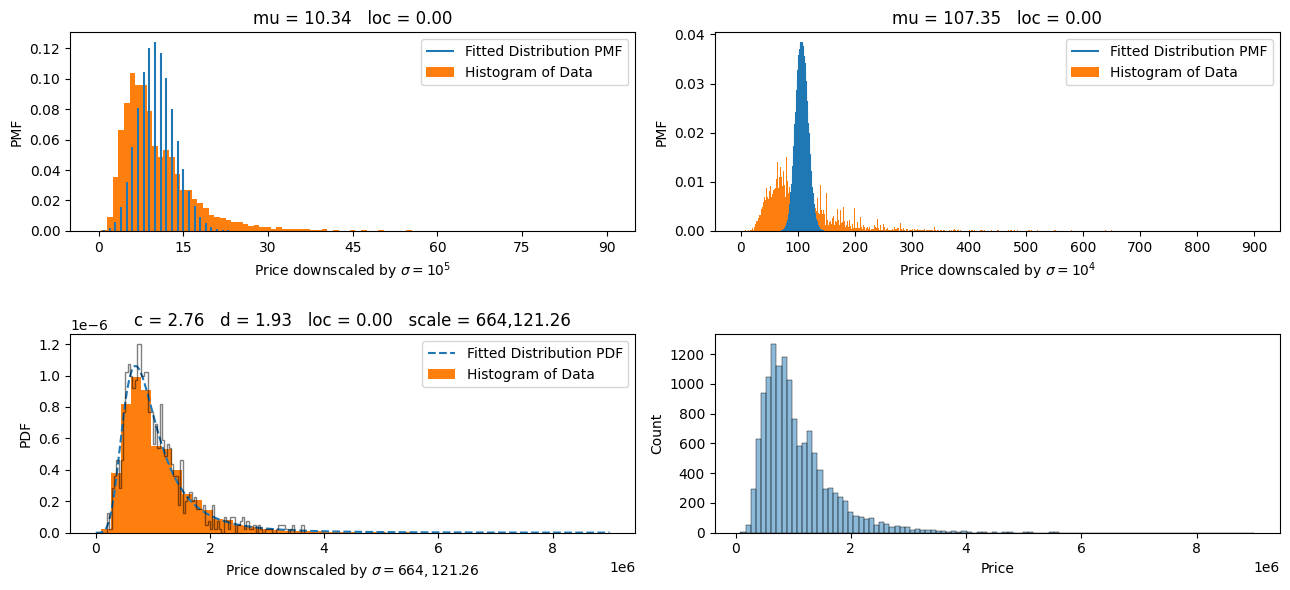

In [2]:
from scipy.stats import fit, poisson, burr

sample = melb_data.Price.apply(lambda price: int(price / 1e5))
poisson_prices_5 = fit(poisson, sample, bounds={
    'mu': (0, 100),
    'loc': (0, 5),
})
assert poisson_prices_5.success

sample = melb_data.Price.apply(lambda price: int(price / 1e4))
poisson_prices_4 = fit(poisson, sample, bounds={
    'mu': (60, 150),
    'loc': (0, 20),
})
assert poisson_prices_4.success


# Downscaling `Price` by some factor between 1e5 and 1e7 yields small parameter bounds for c and d
sample = melb_data.Price.apply(lambda price: price)
burr_prices = fit(burr, sample, bounds={
    'c': (0, 5),
    'd': (0, 5),
    'scale': (1e5, 1e7),
})
assert burr_prices.success

b = burr(c=burr_prices.params.c, d=burr_prices.params.d, scale=burr_prices.params.scale)

fig, axes = plt.subplots(2, 2, figsize=(13, 6))

for ax, poisson_prices, downscale in zip(axes[0, :], [poisson_prices_5, poisson_prices_4], [5, 4]):
    poisson_prices.plot(ax=ax)
    ax.set_title(f'{"   ".join([f"{key} = {param:,.2f}" for key, param in zip(poisson_prices.params._fields, poisson_prices.params)])}')
    ax.set_xlabel(f'Price downscaled by $\sigma = 10^{{{downscale}}}$')

ax = axes[1, 0]
burr_prices.plot(ax=ax)
x = np.arange(0, 5, .1)
ax.plot(x, b.pdf(x), color='k', alpha=.5)
ax.hist(b.rvs(1000), range=(0, 4e6), density=True, bins=100, color='k', alpha=.5, histtype='step')
ax.set_title(f'{"   ".join([f"{key} = {param:,.2f}" for key, param in zip(burr_prices.params._fields, burr_prices.params)])}')
ax.set_xlabel(f'Price downscaled by $\sigma = {burr_prices.params.scale:,.2f}$')

ax = axes[1, 1]
ax = sns.histplot(ax=ax, data=melb_data, x='Price', bins=100, alpha=.5)

fig.tight_layout()
plt.show()

It seems the `Price`, after downscaling by a huge factor of $\sigma$, are [burr (Type III)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.burr.html#scipy.stats.burr) distributed with probability density function
$$
    \varphi_{c, d}(x) = \frac{c d}{x^{c+1}(1+x^{-c})^{d+1}}
$$
The actual distribution $\varphi(p)$ of the unscaled `Price` $p$ is then given by the reverse transformed pdf
$$
    \varphi(p) = \tfrac{1}{\sigma} \varphi_{c, d}\left(\tfrac{p}{\sigma}\right)
$$

In order to categorize the `Price`, we can then use the `.ppf` of our approximate.

In [3]:
n_cats = 10
def classify(b=b, n_cats=n_cats):
    """
    Price categories range from 0, ..., n_cats - 1
    """
    def inner(price):
        price_categories = b.ppf(np.linspace(0, 1, n_cats+1)[::-1])
        for i, price_category in enumerate(price_categories):
            if price >= price_category:
                return n_cats - i
    return inner

melb_data = melb_data.assign(PriceCategory=melb_data['Price'].apply(classify(b=b, n_cats=n_cats)))
melb_data.PriceCategory.describe()

count    13580.000000
mean         4.546613
std          2.915451
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: PriceCategory, dtype: float64

In [4]:
melb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13580 entries, 0 to 13579
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  object        
 1   Address        13580 non-null  object        
 2   Rooms          13580 non-null  int64         
 3   Type           13580 non-null  object        
 4   Price          13580 non-null  float64       
 5   Method         13580 non-null  object        
 6   SellerG        13580 non-null  object        
 7   Date           13580 non-null  datetime64[ns]
 8   Distance       13580 non-null  float64       
 9   Postcode       13580 non-null  float64       
 10  Bedroom2       13580 non-null  int64         
 11  Bathroom       13580 non-null  int64         
 12  Car            13518 non-null  float64       
 13  Landsize       13580 non-null  float64       
 14  BuildingArea   7130 non-null   float64       
 15  YearBuilt      8205

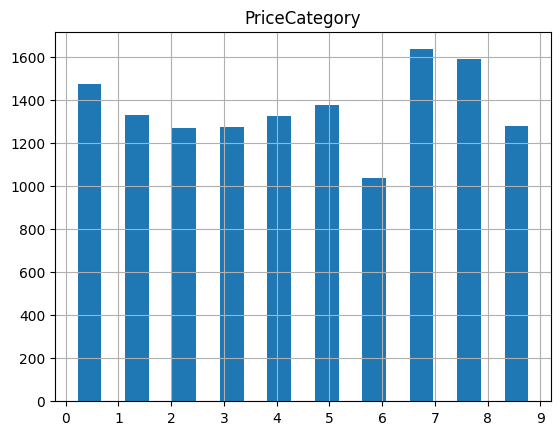

In [5]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

ax = melb_data.hist(column='PriceCategory', bins=n_cats, rwidth=.5)
ax[0, 0].xaxis.set_major_locator(MultipleLocator(1))

In [6]:
melb_data.to_hdf(f'{data_dir}/melb_data_price_categories.h5', key='melb_data', mode='w')

/var/folders/7f/gh6c5k2j1lb85_805l_29r580000gn/T/ipykernel_64630/1000190263.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea',
       'Regionname'],
      dtype='object')]

  melb_data.to_hdf(f'{data_dir}/melb_data_price_categories.h5', key='melb_data', mode='w')
